In [1]:
import numpy as np
import pandas as pd
import csv
import os
import matplotlib
import matplotlib.pyplot as plt
import math
import torch
import spinup
import multiprocessing as mp

from torch.autograd import Variable
from sklearn.linear_model import LinearRegression
from matplotlib import cm
from matplotlib.ticker import LinearLocator
from spinup.algos.pytorch.ddpg.core import MLPActorCritic

%matplotlib notebook

In [2]:
from src import *
from src.constants import DT, MAX_X, MAX_Y, BALL_ERROR_SCALING, BALL_D_ERROR_SCALING, BALL_INTEGRAL_ERROR_SCALING

In [8]:
train = False

In [9]:
with open('src/data/benchmark_trajectory.json') as json_file:
    benchmark_data = json.load(json_file)

In [10]:
t = np.array(benchmark_data['t'])
test_trajectory = np.array(benchmark_data['target'])
benchmark_trajectory = np.array(benchmark_data['trajectory'])
benchmark_angle = np.array(benchmark_data['angle'])
benchmark_u = np.array(benchmark_data['u'])

# Exploration

In [11]:
epoch = 200

In [12]:
root = 'src/data/dyn_pid_controller_1d/exploratory_penality'

In [13]:
def train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size):
    if train:
        spinup.ddpg_pytorch(env_fn_gen(env, reward_fn, w),
                                actor_critic = ac,    
                                ac_kwargs = dict(hidden_sizes=hidden_size, activation=activation), 
                                seed = 0, 
                                steps_per_epoch = 1100, 
                                epochs = epoch, 
                                replay_size = replay_size, 
                                gamma = 0.99, 
                                polyak = 0.995, 
                                pi_lr = 0.001,
                                q_lr = 0.001,
                                batch_size = 500, 
                                start_steps = 15000,
                                act_noise = 0.1,
                                max_ep_len = 400,
                                update_every= 100,
                                num_test_episodes=20,
                                logger_kwargs = dict(output_dir='{}/{}'.format(root, name), exp_name='test'),
                                )
    trained_ac = torch.load('{}/{}/pyt_save/model.pt'.format(root, name))
    evaluator_ddpg = env()
    history_ddpg, error_ddpg, u_ddpg, angle_ddpg, loss_ddpg, kp, kd, ki = evaluator_ddpg.simulate(trained_ac, test_trajectory[0, :])

    w = trained_ac.pi.state_dict()

    saved_weights = {}
    for key, value in w.items():
        saved_weights[key] = value.detach().numpy().tolist()

    with open('{}/{}/pyt_save/model.json'.format(root, name), 'w') as json_file:
        json.dump(saved_weights, json_file, indent=1)
    
    print("MSE :", loss_ddpg)

    log = pd.read_csv('{}/{}/progress.txt'.format(root, name), sep='\t')
    fig, axs = plt.subplots(3, 1, sharex=True, figsize=(10, 10))
    axs[0].plot(log['AverageEpRet'].rolling(window=20).mean(), linewidth=1)
    axs[0].set_ylabel('AvergeEpRet')
    axs[0].legend()
    axs[0].set_xlabel('Epoch')

    axs[1].plot(log['LossPi'])
    axs[1].set_ylabel('Actor loss')
    axs[1].set_xlabel('Epoch')

    axs[2].plot(log['LossQ'])
    axs[2].set_ylabel('Critic loss')
    axs[2].set_xlabel('Epoch')

    fig, axs = plt.subplots(4, 1, sharex=True, figsize=(10, 10))

    axs[0].plot(t, history_ddpg, label='x_ddpg')
    axs[0].plot(t, test_trajectory[0, :], label='target')
    axs[0].set_ylabel('Ball position [m]')
    axs[0].set_ylim([-MAX_X, MAX_X])
    axs[0].legend()

    axs[1].plot(t, error_ddpg, label='x')
    axs[1].set_ylabel('Ball error [m]')
    axs[1].set_ylim([-MAX_X, MAX_X])
    axs[1].legend()

    axs[2].plot(t, angle_ddpg, label='angle_ddpg')
    axs[2].plot(t, u_ddpg, label='u_ddpg')
    axs[2].set_ylabel('Motor x angle [deg]')
    axs[2].legend()
    
    axs[3].plot(t, kp, label='kp')
    axs[3].plot(t, kd, label='kd')
    axs[3].plot(t, ki, label='ki')
    axs[3].set_ylabel('PID weights')
    axs[3].legend()

    plt.show()
    
    w = trained_ac.pi.state_dict()

    saved_weights = {}
    for key, value in w.items():
        saved_weights[key] = value.detach().numpy().tolist()
    
    with open('{}/{}/pyt_save/model.json'.format(root, name), 'w') as json_file:
        json.dump(saved_weights, json_file, indent=1)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.0190946], dtype=float32), array([-0.03742577], dtype=float32), array([-0.00057558], dtype=float32))


/home/benoit/.local/lib/python3.6/site-packages/gym/logger.py:30: UserWarning: WARN: Box bound precision lowered by casting to float32
  warnings.warn(colorize('%s: %s'%('WARN', msg % args), 'yellow'))


MSE : -0.20217597050053157


<IPython.core.display.Javascript object>


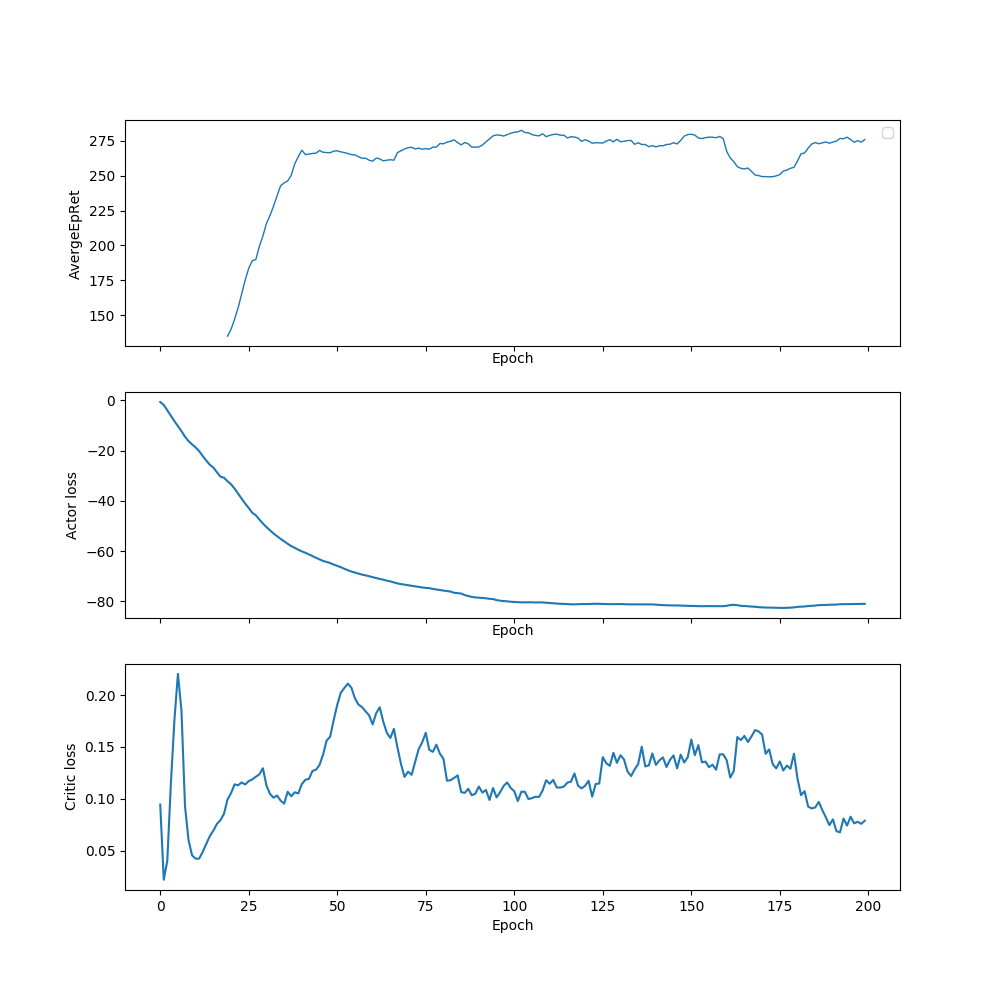

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


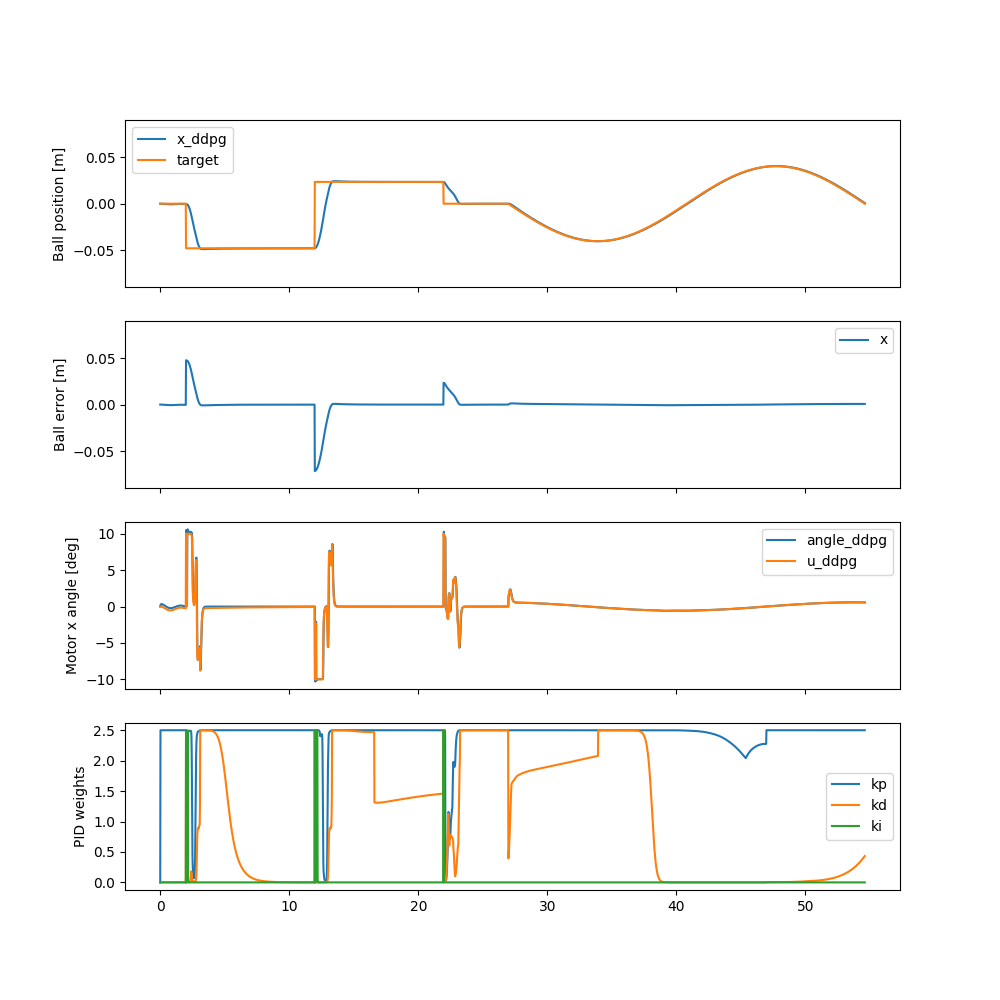

In [14]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[50]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.05327095], dtype=float32), array([0.0393094], dtype=float32), array([0.00230852], dtype=float32))
MSE : -0.2388288764985233


<IPython.core.display.Javascript object>


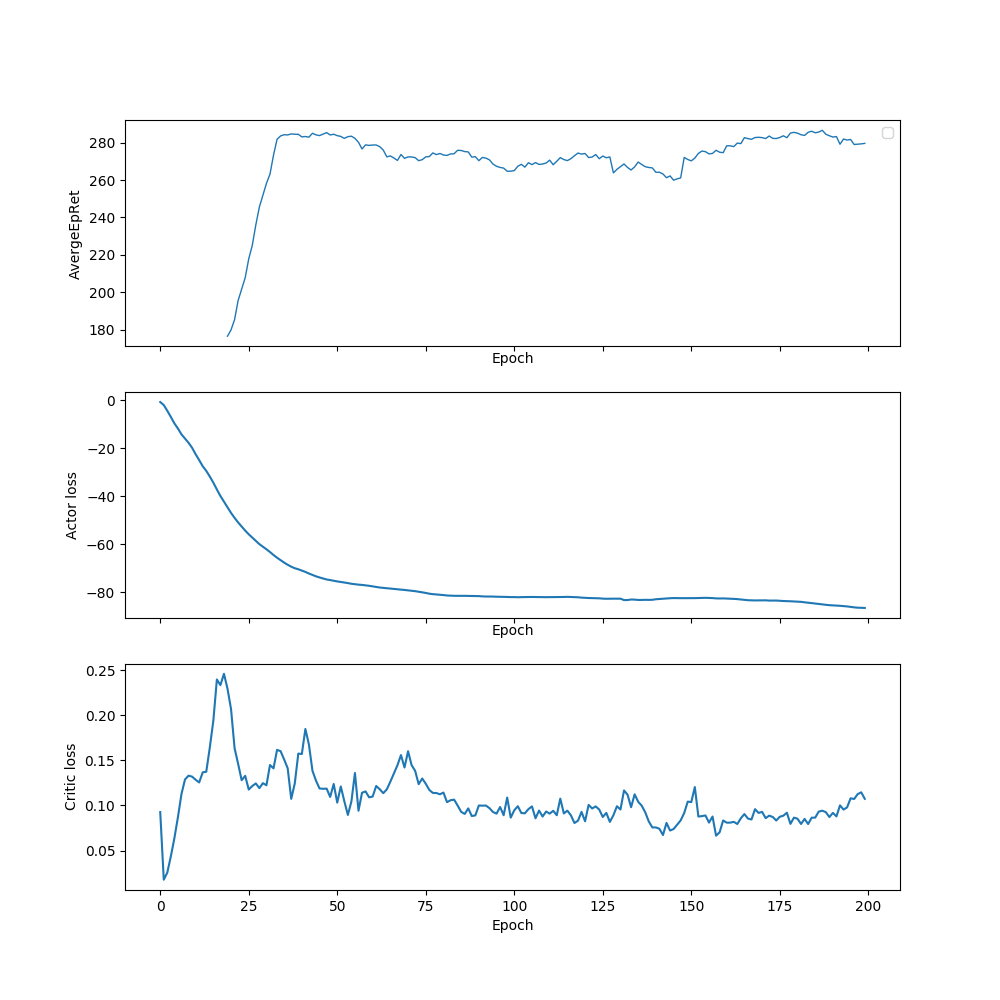

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


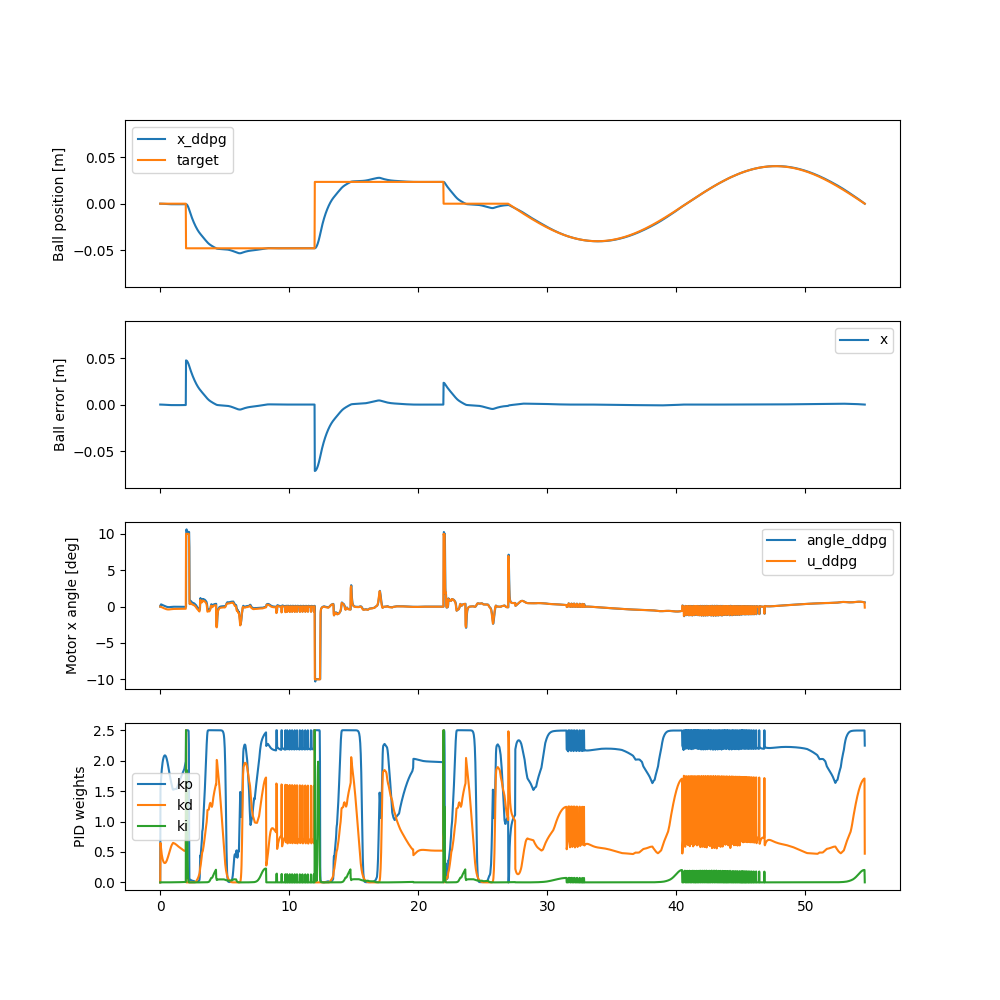

In [15]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[100]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.01518482], dtype=float32), array([0.06813245], dtype=float32), array([-0.00111034], dtype=float32))
MSE : -0.19704561135632717


<IPython.core.display.Javascript object>


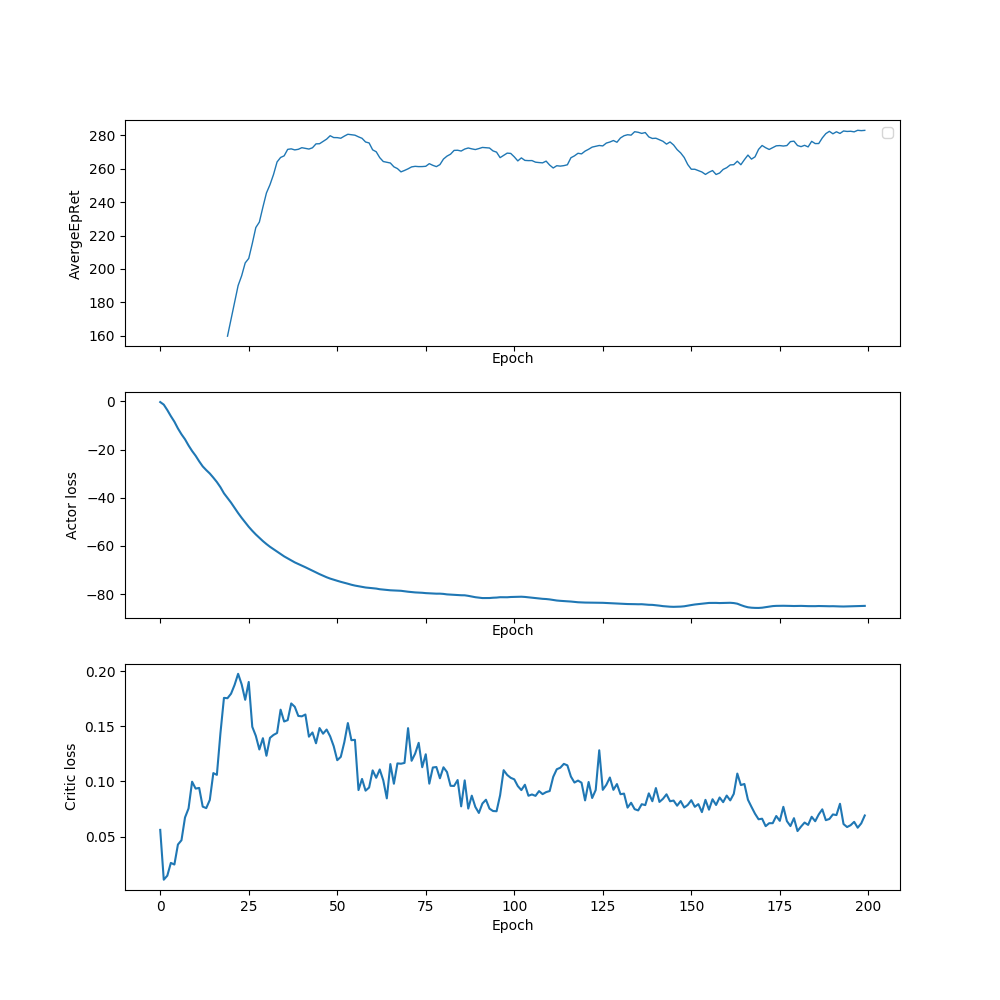

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


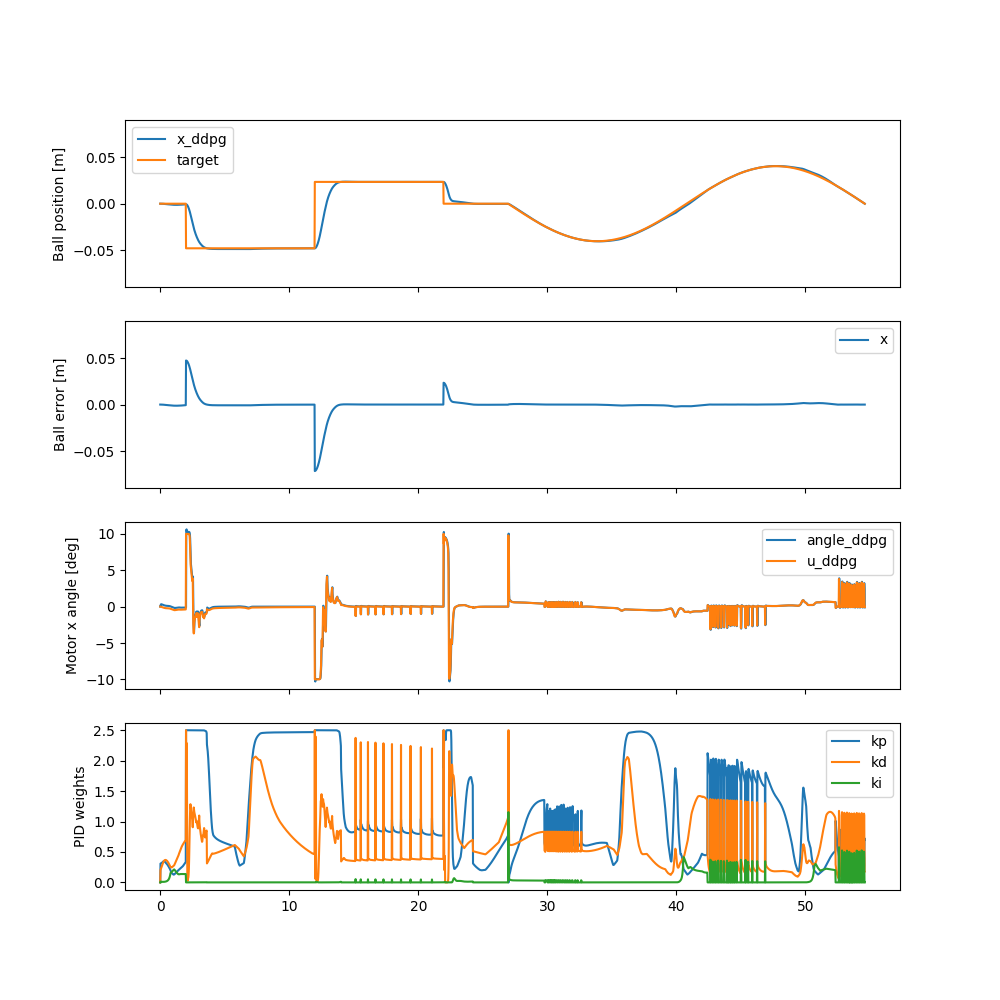

In [16]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200]
activation = torch.nn.ReLU
replay_size = 75000
name='lep_0.6_[200]_relu_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.00191758], dtype=float32), array([-0.02138224], dtype=float32), array([0.00077819], dtype=float32))
MSE : -0.2055302401693574


<IPython.core.display.Javascript object>


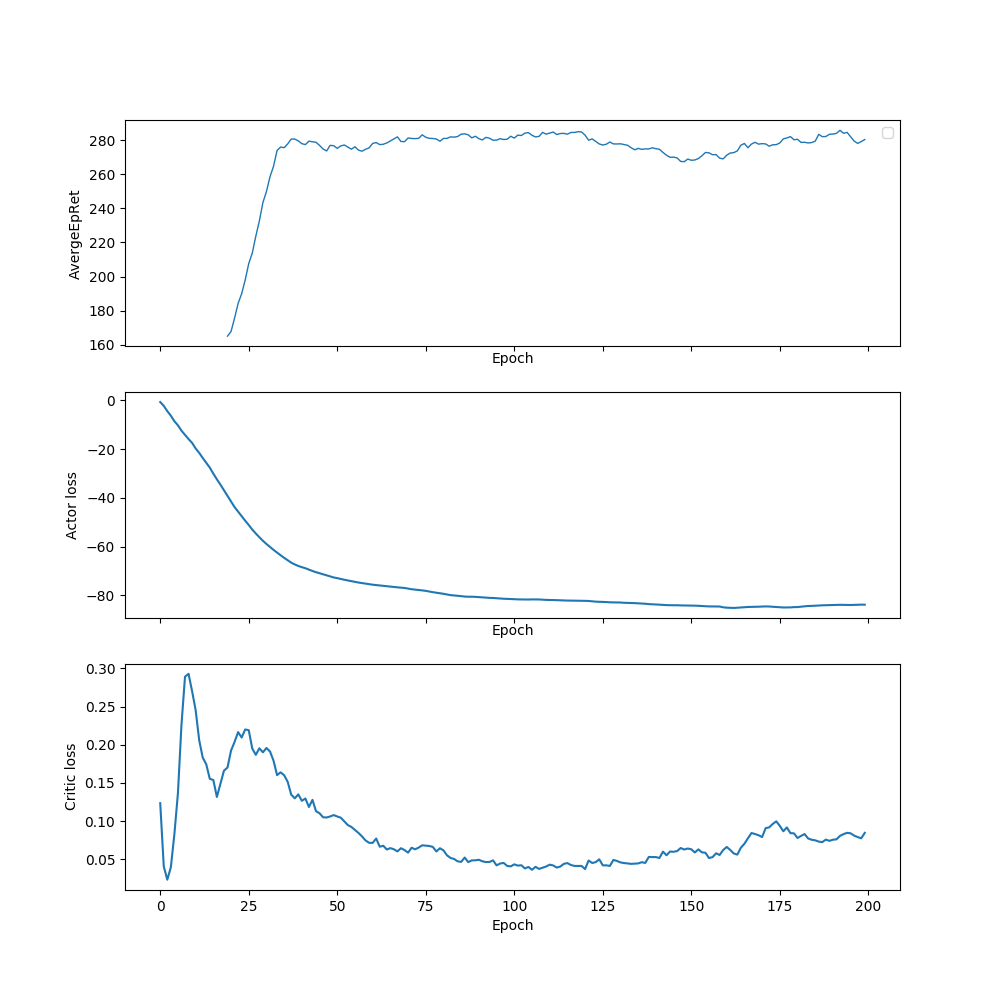

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


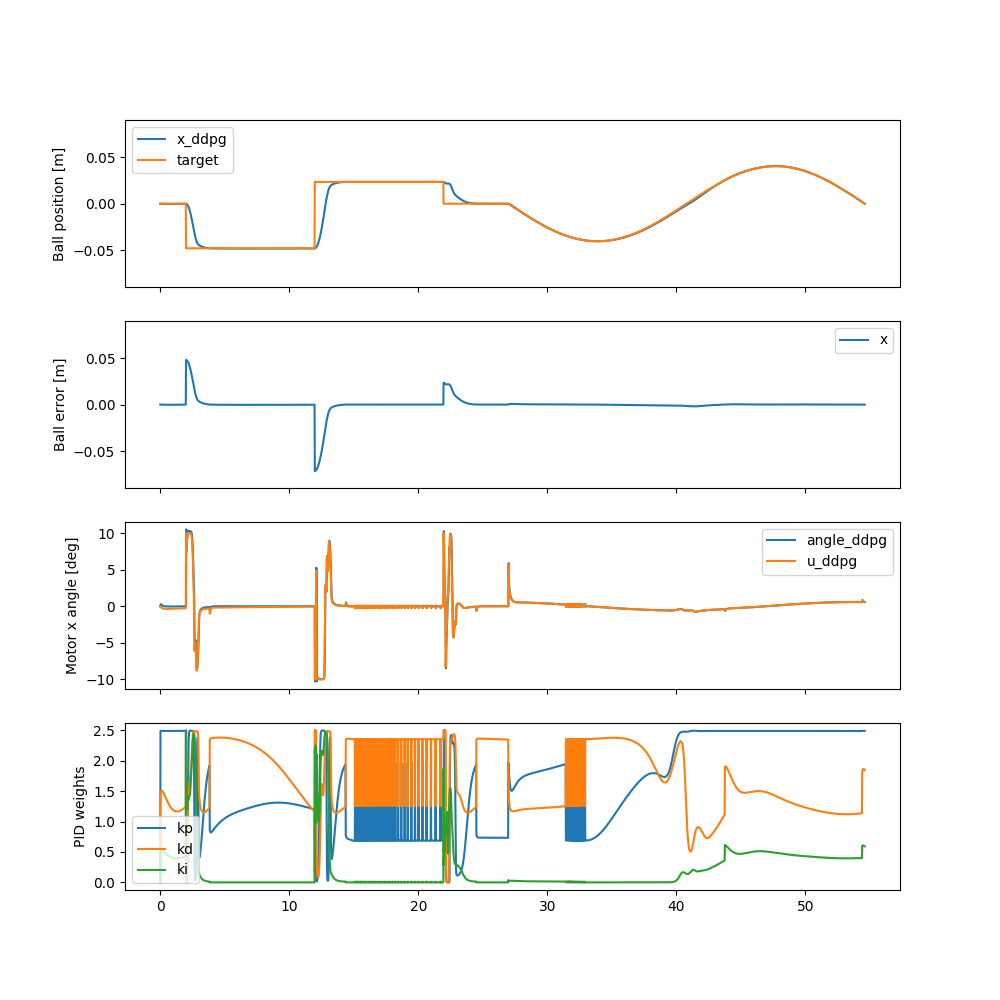

In [17]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50] 
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.00429659], dtype=float32), array([0.06458019], dtype=float32), array([-0.00082992], dtype=float32))
MSE : -0.19587952105017892


<IPython.core.display.Javascript object>


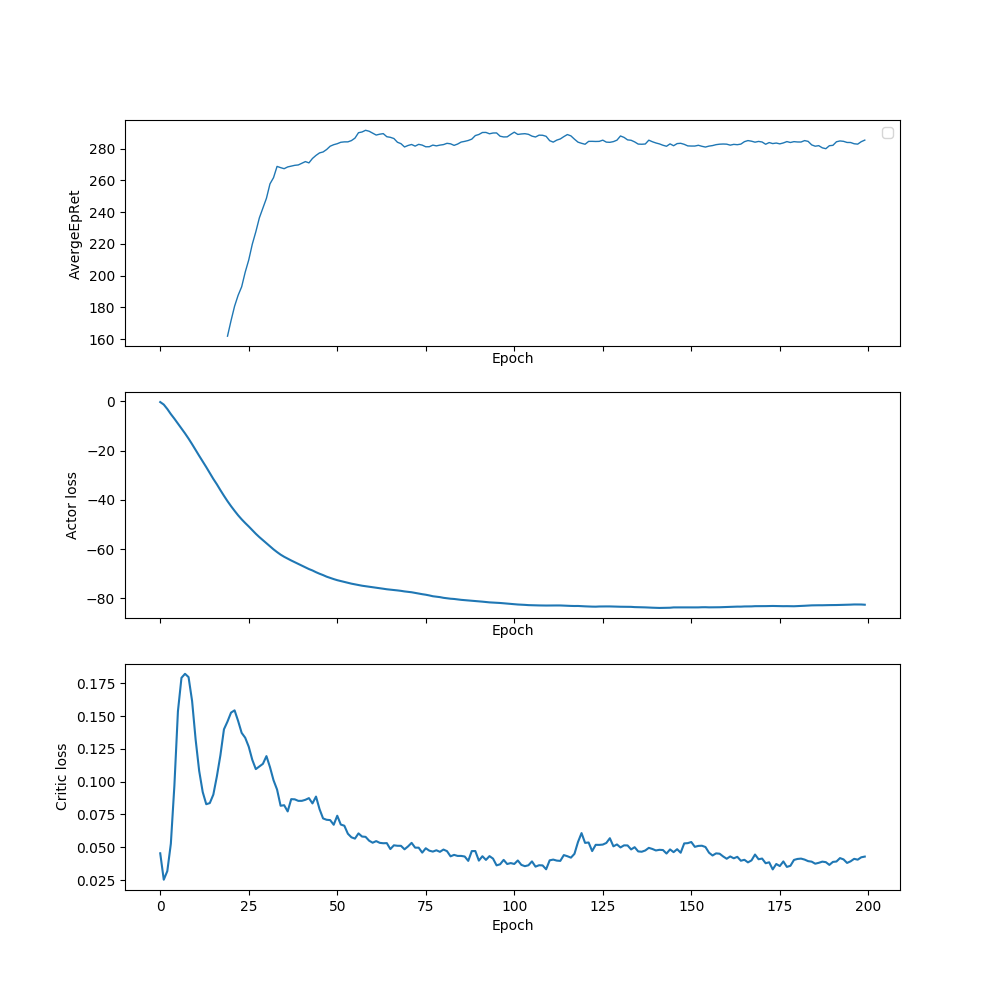

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


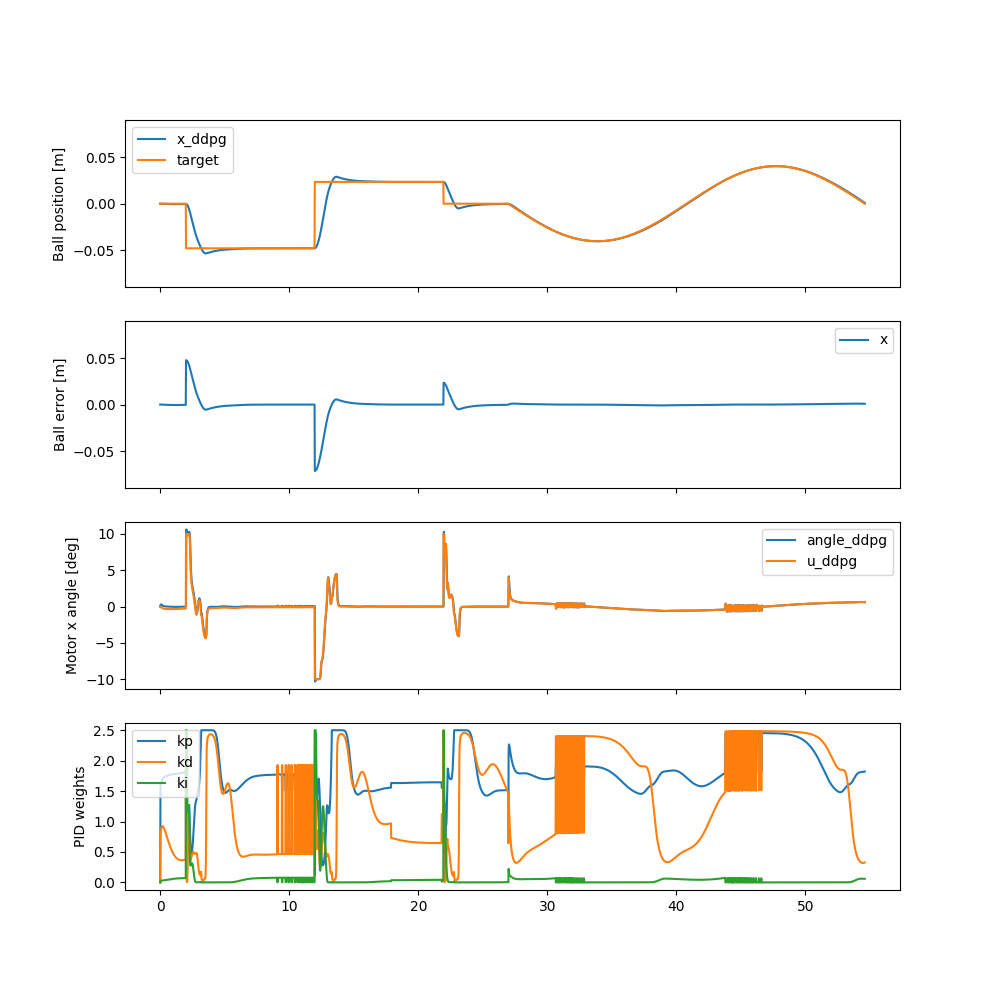

In [18]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.03187185], dtype=float32), array([0.06071527], dtype=float32), array([-0.00015885], dtype=float32))
MSE : -0.20007071352308253


<IPython.core.display.Javascript object>


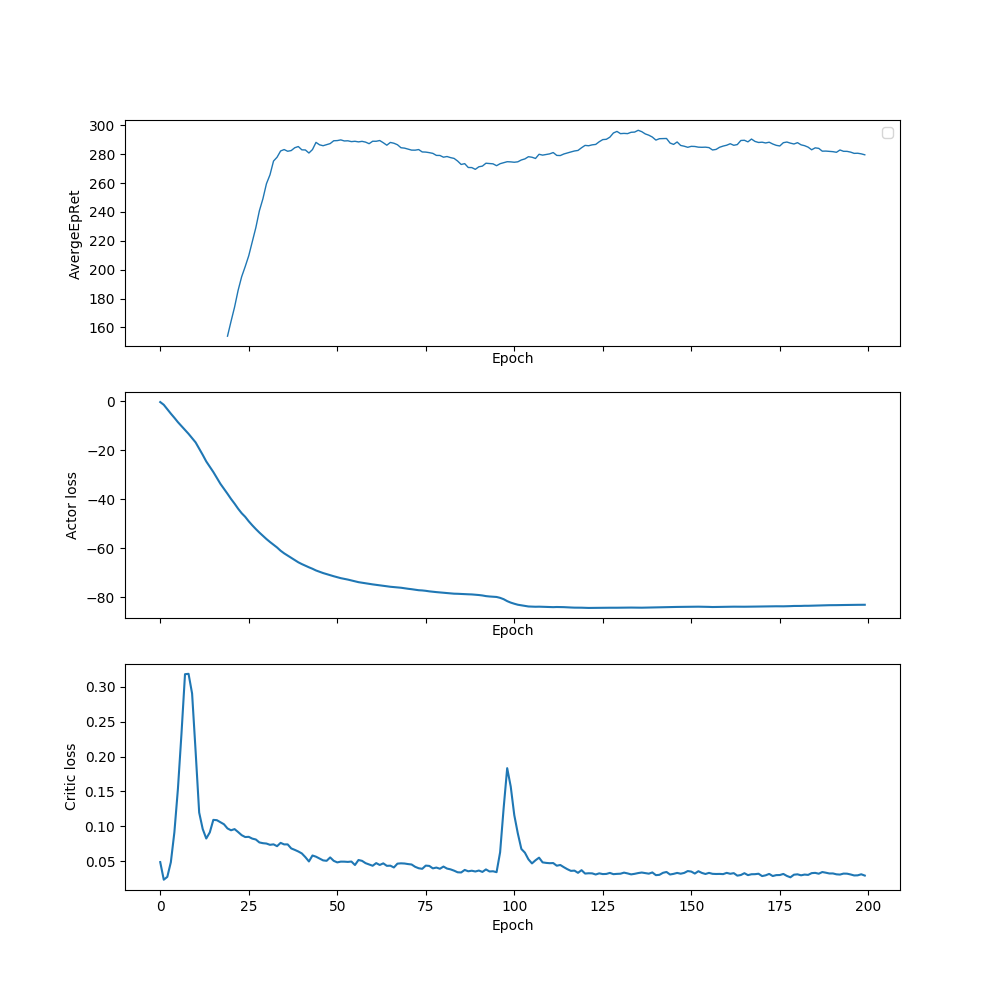

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


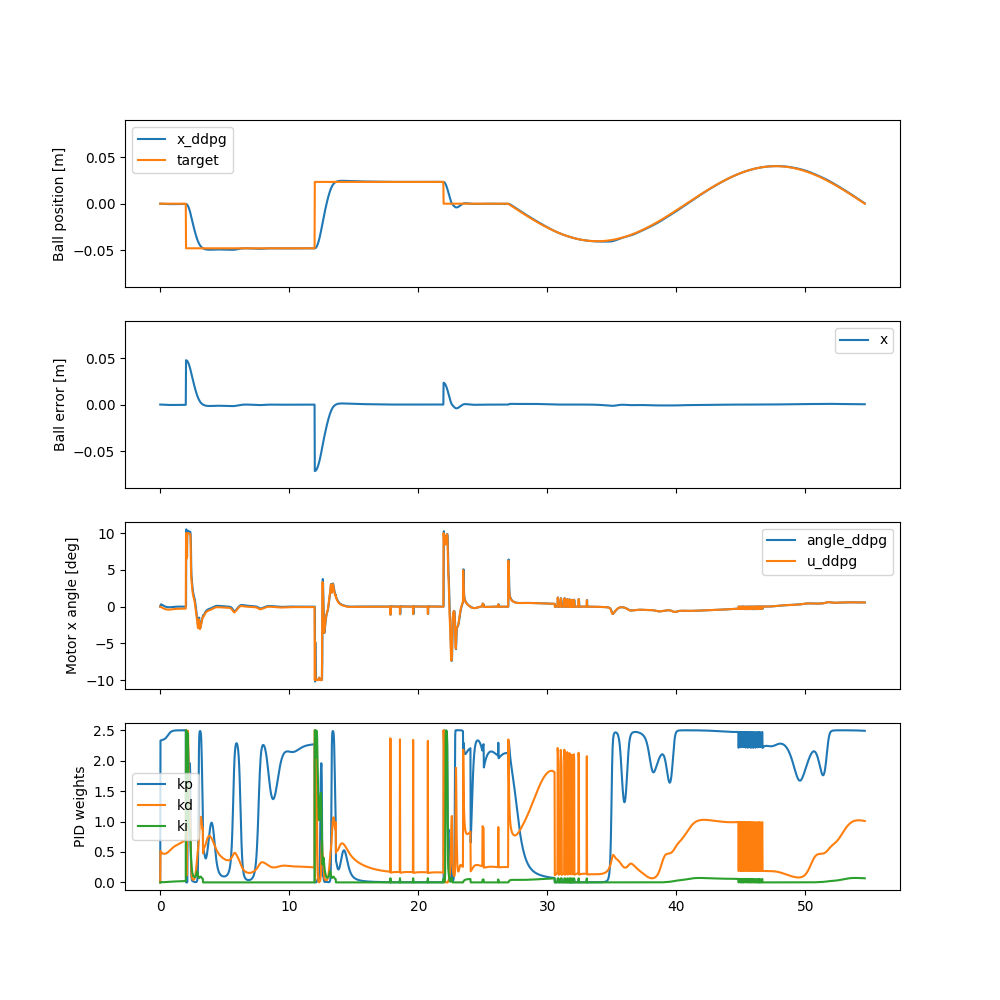

In [19]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [200]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[200]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.00400941], dtype=float32), array([0.03601381], dtype=float32), array([0.00169033], dtype=float32))
MSE : -0.19788465870360877


<IPython.core.display.Javascript object>


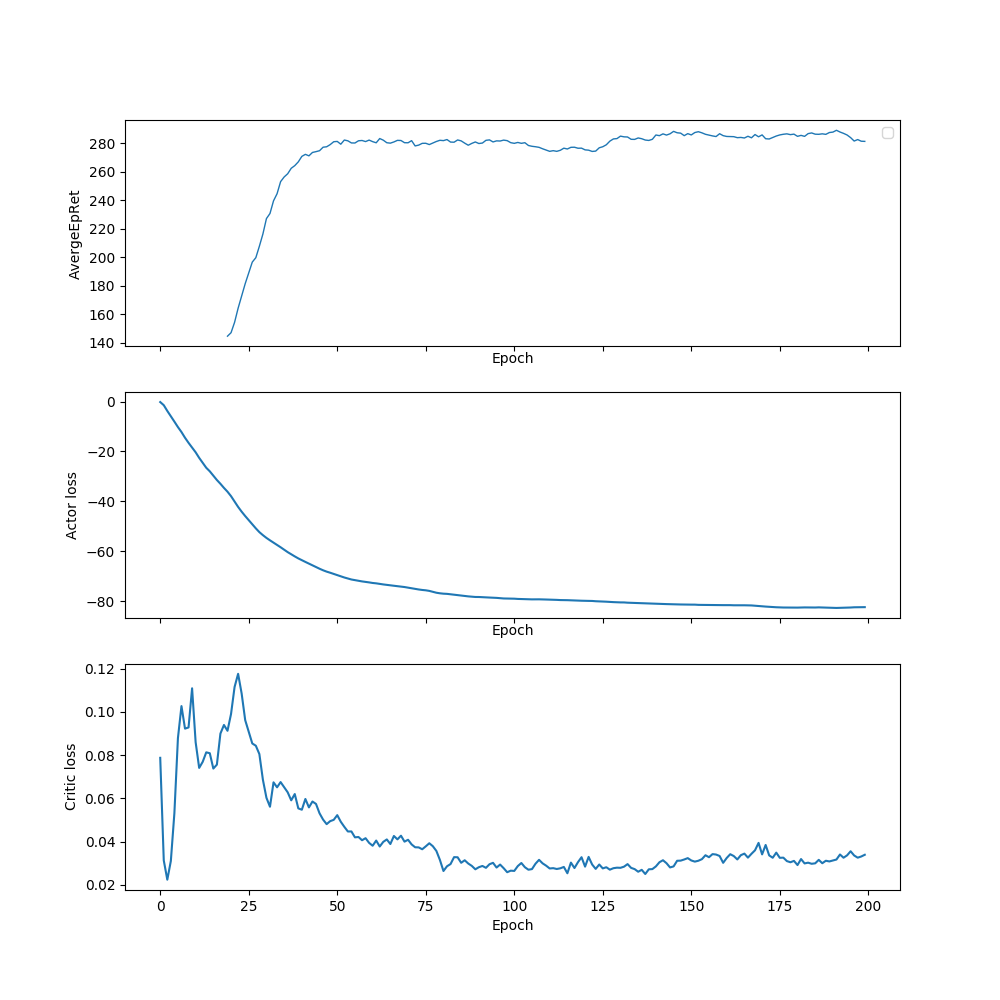

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


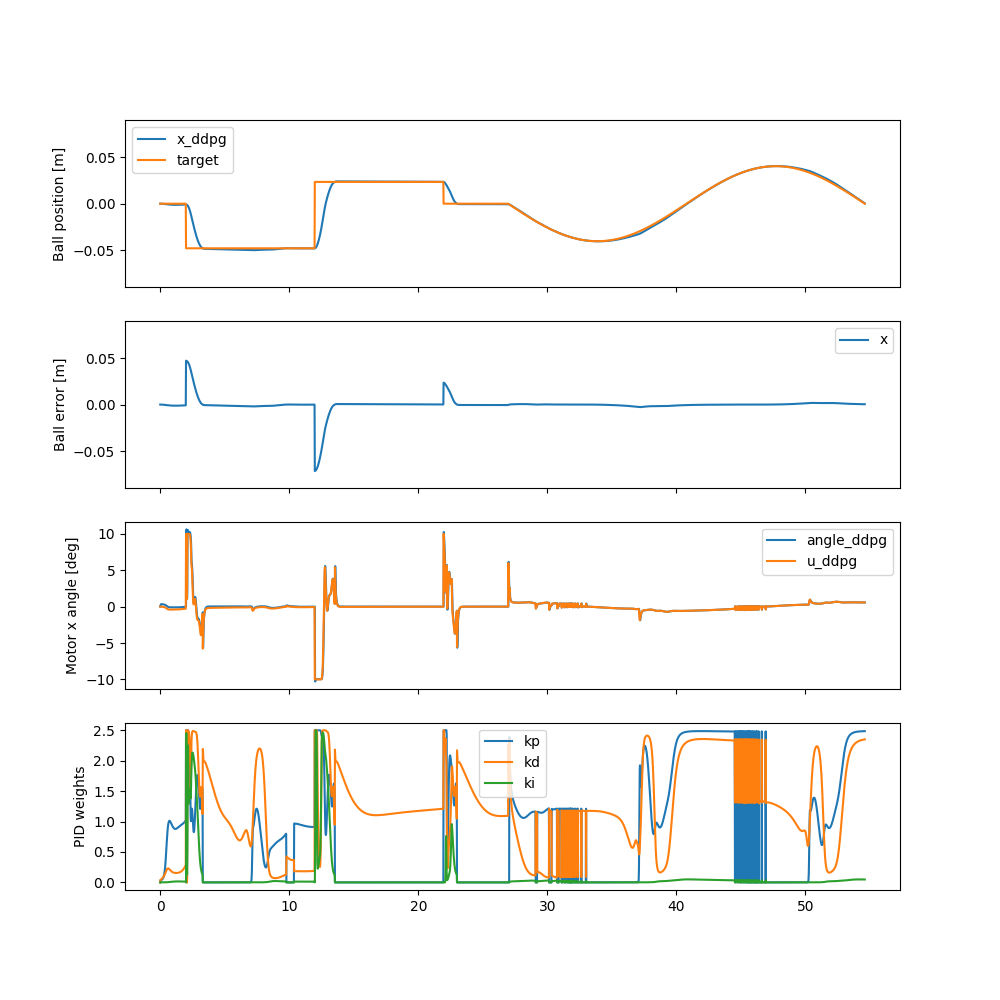

In [20]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50,25]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50,25]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.01506906], dtype=float32), array([0.00322064], dtype=float32), array([-0.00146819], dtype=float32))
MSE : -0.1999694596746847


<IPython.core.display.Javascript object>


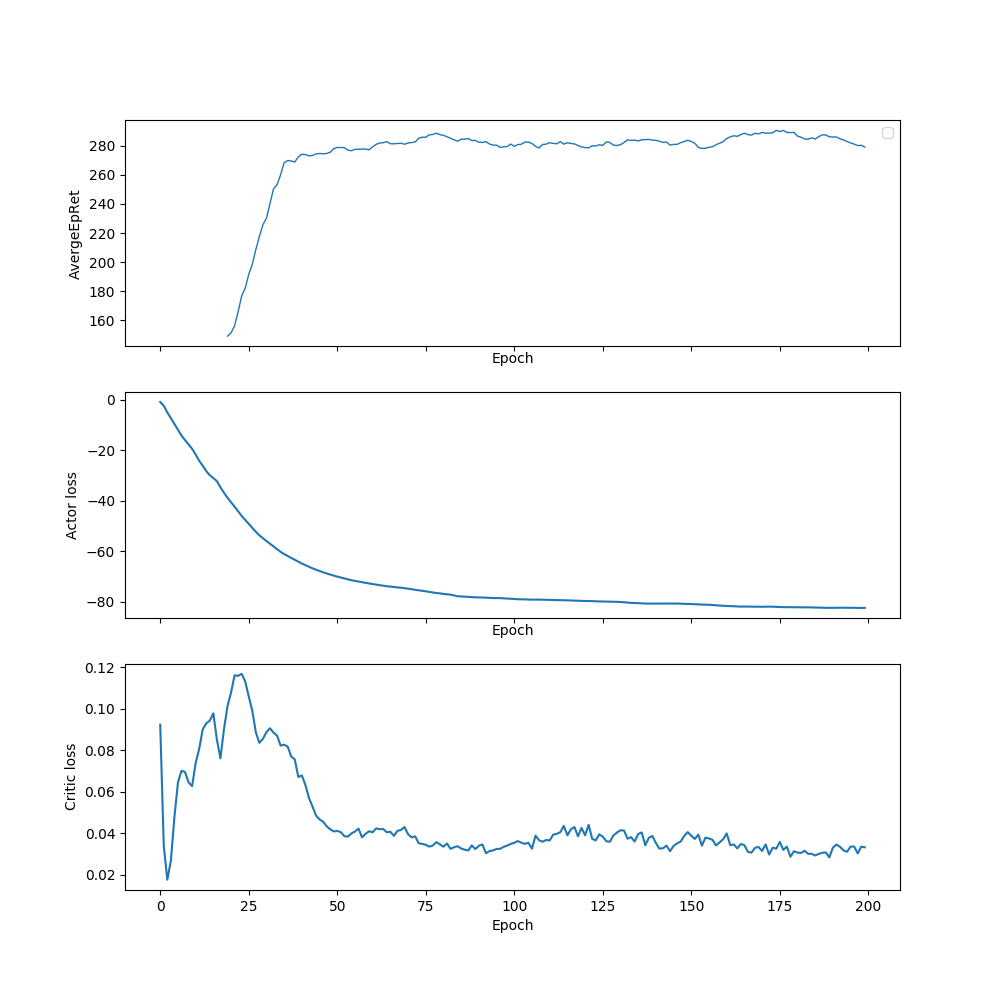

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


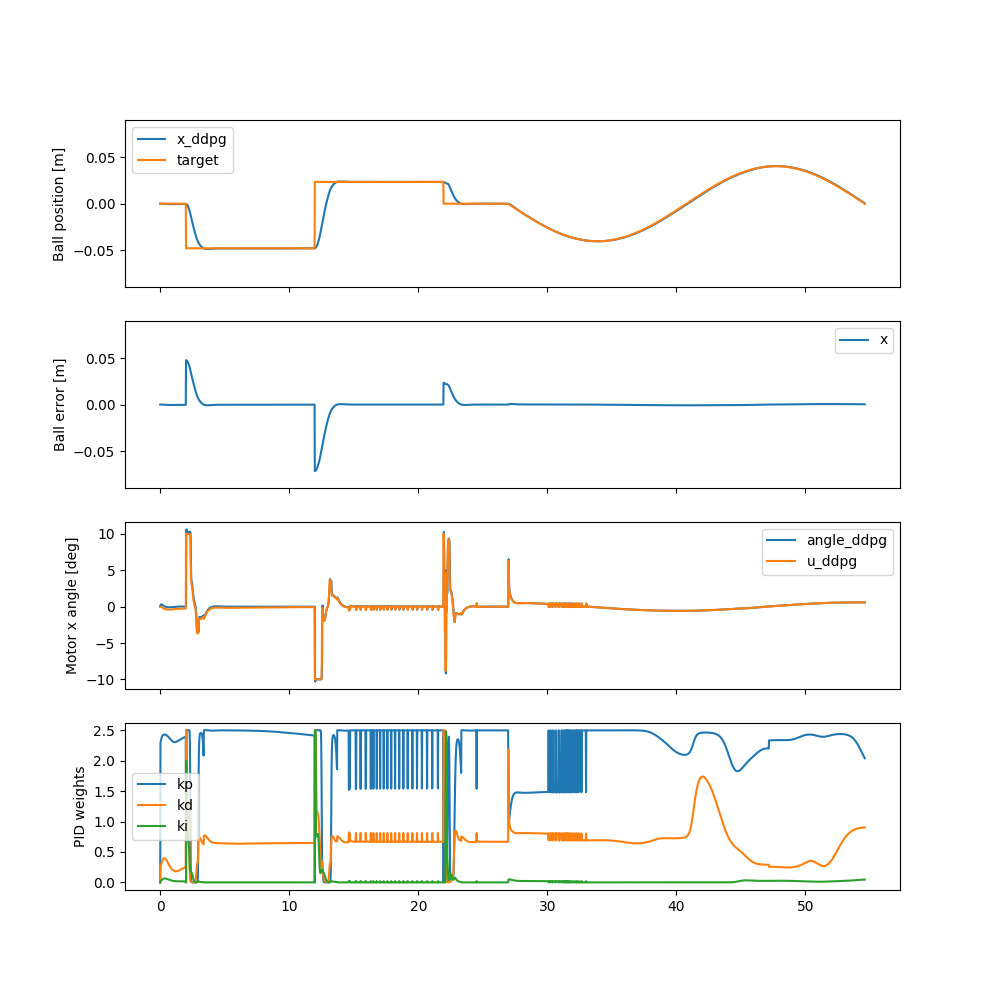

In [21]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [50,50]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[50,50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([0.03340068], dtype=float32), array([-0.03138355], dtype=float32), array([-0.00019233], dtype=float32))
MSE : -0.19703997157404943


<IPython.core.display.Javascript object>


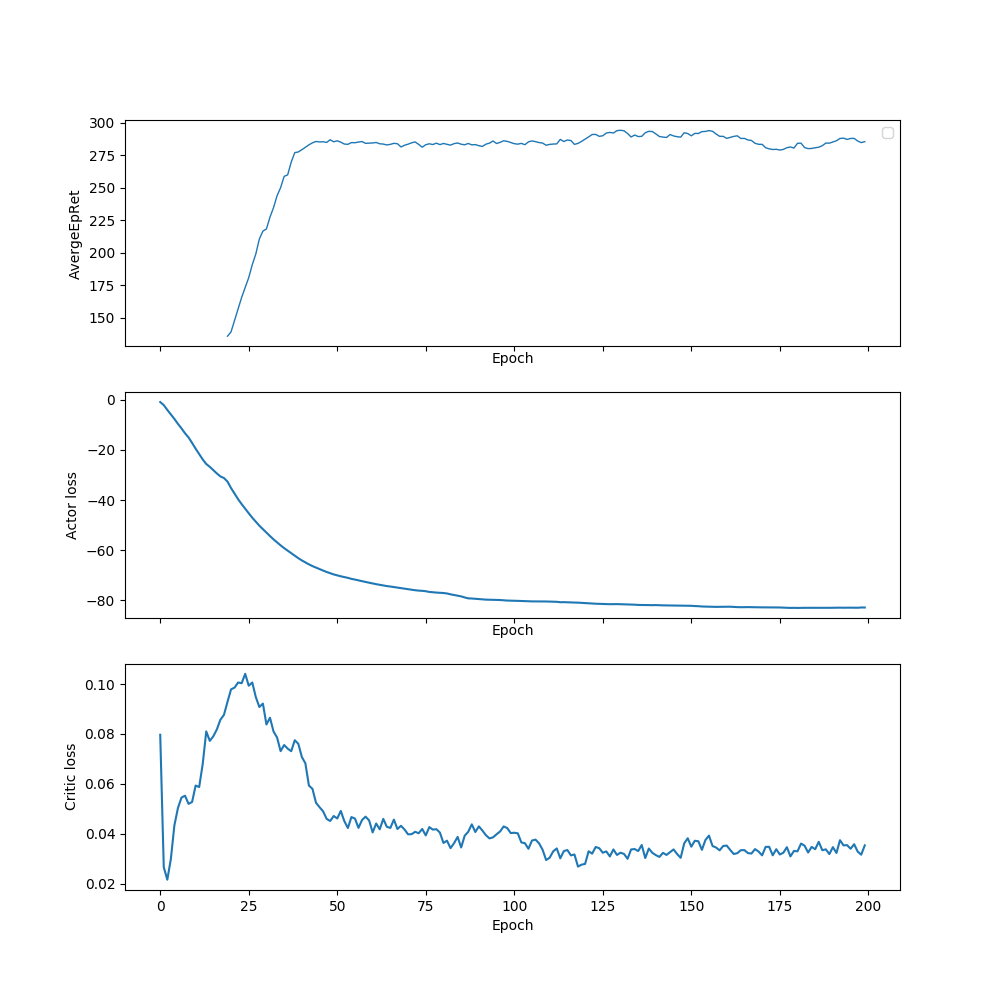

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


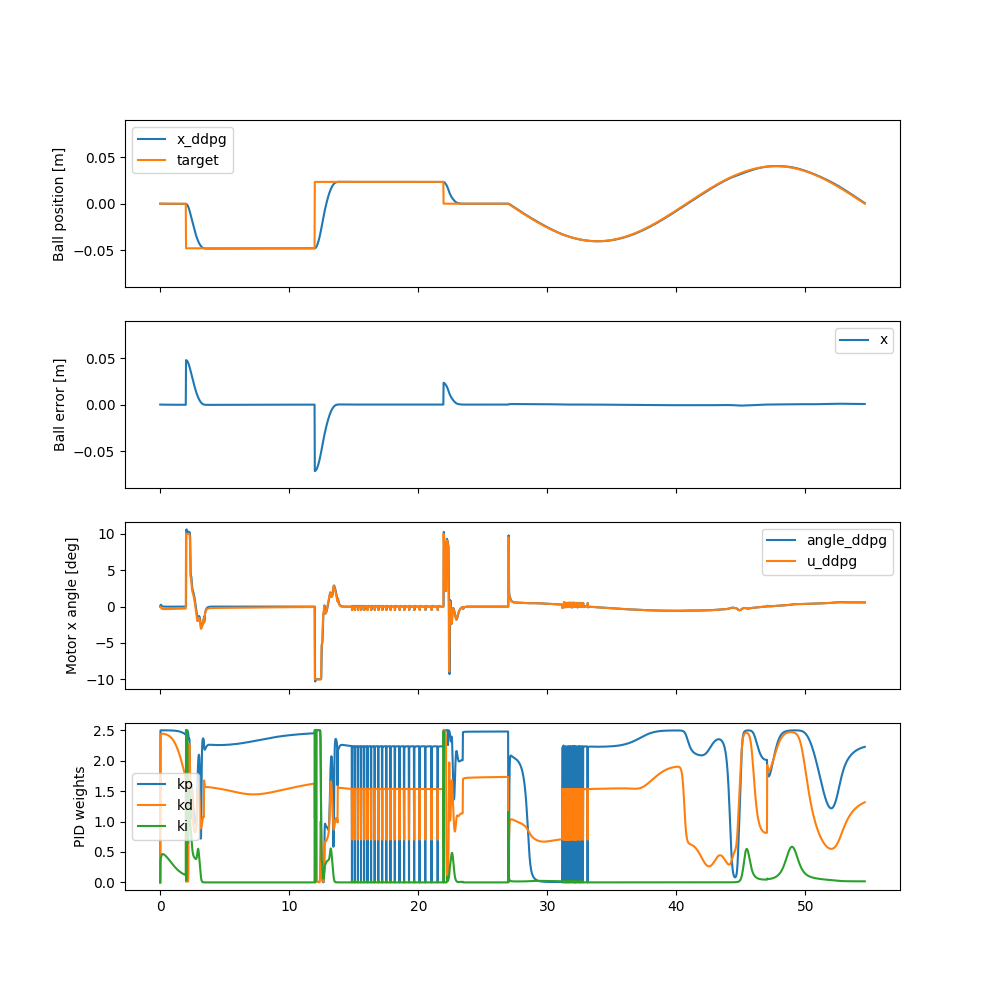

In [22]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,50]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100,50]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)

{'phy_coef': 217.59587893981333, 'phy_i_coef_u': 217.17632054282475, 'phy_i_coef_s': 7274.250340039798, 'speed_scaling': 20000}
{'weights': [0.15728610754013062, 0.001560160541534424, 0.02386050671339035], 'bias': 0.05579447001218796}
{'phy_i_coef': [-0.024378080500752557, -0.003229237402526039], 's_scaling': 1.0, 'sin_scaling': 7.0}
(array([-0.03579127], dtype=float32), array([-0.05254451], dtype=float32), array([-0.00101291], dtype=float32))
MSE : -0.19979646919341004


<IPython.core.display.Javascript object>


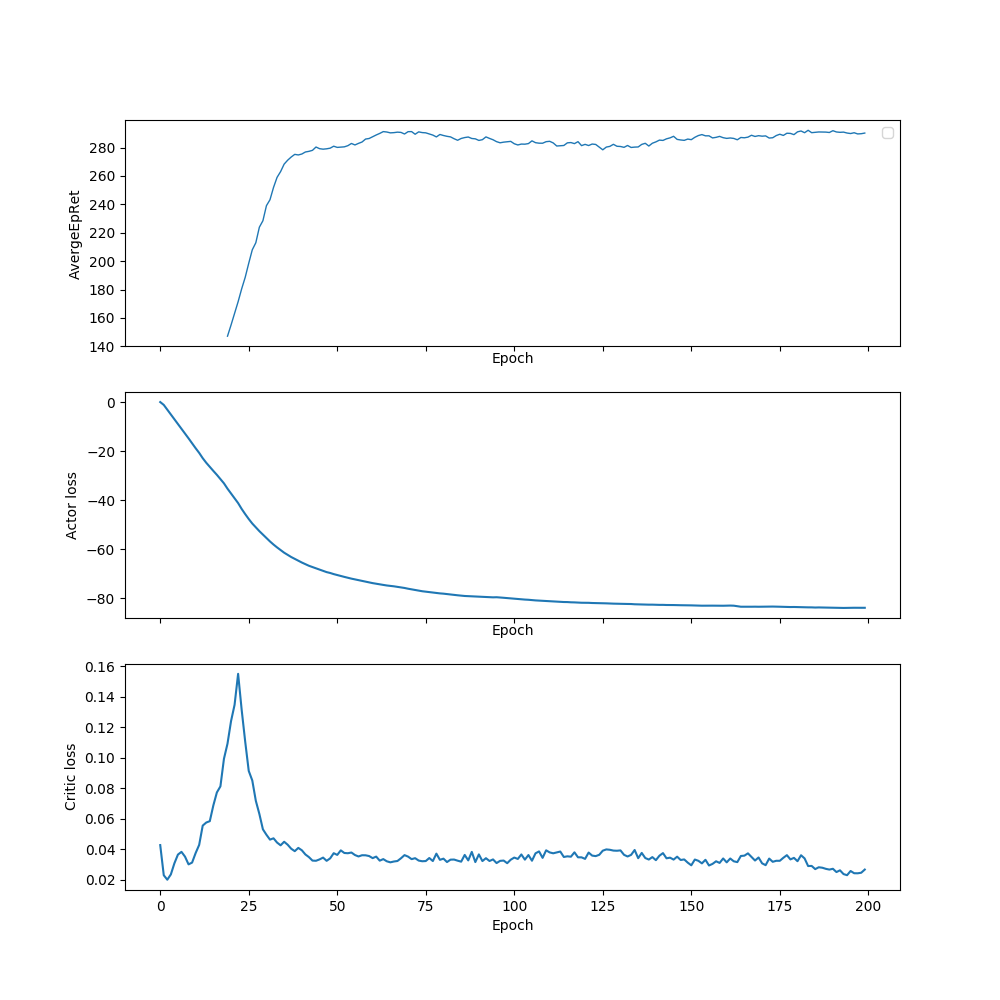

No handles with labels found to put in legend.


<IPython.core.display.Javascript object>


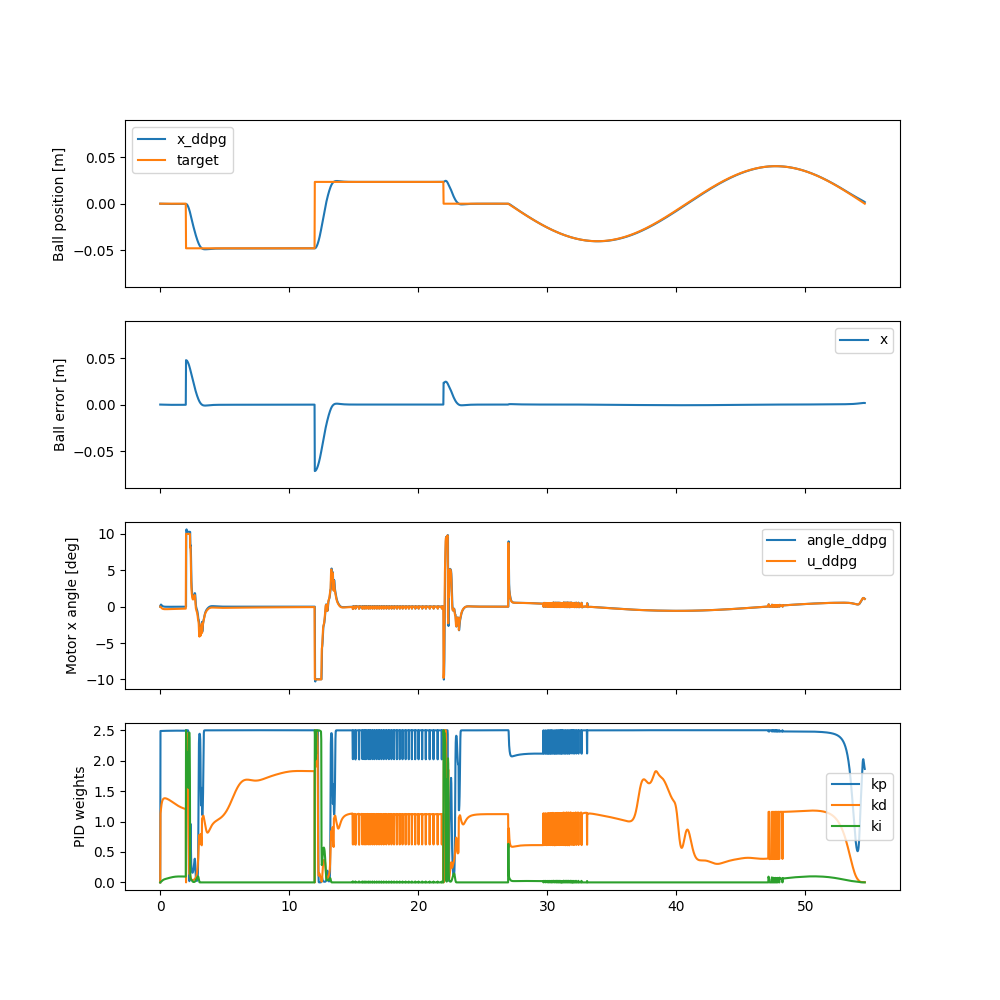

In [23]:
env = BBEnvPid1D
ac = PidActorCritic
reward_fn = linear_e_reward_penality
w = 0.6
hidden_size = [100,100]
activation = torch.nn.Sigmoid
replay_size = 75000
name='lep_0.6_[100,100]_sigmoid_75000'
train_ddpg(env, ac, reward_fn, w, hidden_size, activation, name, replay_size)